<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Convex_VECM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***This class implements a Nonlinear Vector Error Correction Model (VECM).<br><br>It extends the conventional VECM framework by incorporating a quadratic adjustments to the long-run equilibrium.***

$$
\Delta y_{i,t}
= \alpha_{1,i} \, \mathrm{ECT}_{t-1}
+ \alpha_{2,i} \, (\mathrm{ECT}_{t-1})^2
+ \sum_{k=1}^{p-1} \Gamma_{i,k} \, \Delta y_{t-k}
+ \varepsilon_{i,t}.
$$


# Nonlinear VECM

In [1]:
import numpy as np
from scipy import stats
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, VECM
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd

class NonlinearVECM:
    def __init__(self, data, max_lags=3, deterministic = 'nc'):
        """
        Implements a Vector Error Correction Model (VECM) with nonlinear adjustment.

        This model extends the standard VECM by allowing for nonlinearity in the
        error correction terms. It estimates separate linear and quadratic
        adjustment coefficients for each equation in the system.

        Parameters
        ----------
        data : pd.DataFrame or np.array
            Time series data with shape (T, n_vars), where T is the number of
            observations and n_vars is the number of variables.
        max_lags : int, optional
            Maximum number of lags to consider for the VAR model used to determine
            the optimal lag order. Default is 5.

        Attributes
        ----------
        data : np.array
            The input time series data.
        max_lags : int
            Maximum number of lags considered.
        n_vars : int
            Number of variables in the system.
        T : int
            Number of observations.
        p : int
            Optimal lag order determined by AIC.
        beta : np.array
            Estimated cointegrating vector.
        theta : np.array
            Estimated adjustment parameters (linear and quadratic).
        alpha_y_star : np.array
            Linear adjustment coefficients.
        alpha_prime : np.array
            Quadratic adjustment coefficients.
        gamma : np.array
            Short-run dynamics coefficients (if p > 1).
        residuals : np.array
            Model residuals.
        fitted : np.array
            Fitted values.
        theta_se : np.array
            Bootstrap standard errors for the estimated parameters.

        Methods
        -------
        determine_lag_order()
            Determines the optimal lag order using AIC.
        estimate_beta()
            Estimates the cointegrating vector using Johansen's cointegration test.
        estimate_nonlinear_adjustment()
            Estimates the nonlinear adjustment parameters.
        bootstrap_standard_errors(n_bootstrap=1000)
            Computes bootstrap standard errors for the estimated parameters.
        test_nonlinearity()
            Tests for the significance of nonlinear terms in each equation.
        cointegration_details()
            Returns detailed cointegration test results.
        fit()
            Fits the complete model.
        """

        self.data = data.values if hasattr(data, 'values') else data
        self.max_lags = max_lags
        self.n_vars = self.data.shape[1]
        self.T = self.data.shape[0]
        self.deterministic = deterministic

    def determine_lag_order(self):
        """Determine optimal lag order using AIC with error handling."""
        model = VAR(self.data)
        for lags in range(self.max_lags, 0, -1):  # Try decreasing lags
            try:
                results = select_order(model.endog, maxlags=lags)
                self.p = results.aic
                return self.p
            except np.linalg.LinAlgError:
                print(f"Warning: SVD did not converge for maxlags={lags}. Trying lower value.")
                continue  # Try next lower lag value
        raise ValueError("SVD did not converge for any maxlags. Unable to determine lag order.")

    def estimate_beta(self):
        """
        Estimate cointegrating vector(s) using proper rank selection
        """
        coint_result = select_coint_rank(
            self.data,
            det_order=0,
            k_ar_diff=self.p,
            method='trace'
        )

        print("\nCointegration Test Results:")
        print(f"Number of cointegrating relations: {coint_result.rank}")
        print("\nTrace Statistics:")
        for i, stat in enumerate(coint_result.test_stats):
            print(f"H0: rank ≤ {i}: {stat:.4f}")
            print(f"Critical values: {coint_result.crit_vals[i]}")

        if coint_result.rank == 0:
            raise ValueError("No cointegration found in the data")
        elif coint_result.rank == self.n_vars:
            raise ValueError("System is stationary (full rank)")
        else:
            vecm = VECM(
                self.data,
                k_ar_diff=self.p,
                deterministic=self.deterministic,
                coint_rank=coint_result.rank
            )
            vecm_fit = vecm.fit()

            # Store full beta matrix for multiple cointegrating relations
            self.beta_matrix = vecm_fit.beta

            # For single cointegrating relation, normalize as y2 - y1
            if coint_result.rank == 1:
                self.beta = vecm_fit.beta.reshape(-1)
                # Allow custom normalization
                self.normalize_beta()
            else:
                self.beta = None  # Only defined for rank 1

        self.coint_rank = coint_result.rank
        return self.beta_matrix

    def normalize_beta(self, norm_index=0, target_sign=-1):
        """
        Normalize cointegrating vector with flexible specification

        Parameters:
        -----------
        norm_index : int
            Index of element to normalize on
        target_sign : int
            Desired sign (+1 or -1) for the normalizing element
        """
        if self.beta is not None:
          norm_value = self.beta[norm_index]
          if norm_value == 0:
              raise ValueError(f"Cannot normalize on zero element at index {norm_index}. "
                              f"Choose a different norm_index or skip normalization.")
        self.beta = self.beta / abs(norm_value) * target_sign

    def prepare_short_run_matrices(self):
        """
        Prepare short-run coefficient matrices with proper structure
        """
        if self.p > 1:
            n_sr_params = (self.p - 1) * self.n_vars * self.n_vars
            gamma_start = 2  # After ECT terms
            gamma_values = self.theta[gamma_start:gamma_start + n_sr_params, :]

            # Reshape considering actual lag structure
            self.gamma = []
            pos = 0
            for lag in range(self.p - 1):
                lag_matrix = np.zeros((self.n_vars, self.n_vars))
                for i in range(self.n_vars):
                    for j in range(self.n_vars):
                        lag_matrix[i,j] = gamma_values[pos, i]
                        pos += 1
                self.gamma.append(lag_matrix)

    def estimate_nonlinear_adjustment(self):
        """
        Estimate nonlinear adjustment parameters with separate coefficients for each equation
        """
        # Construct error correction terms
        ect = np.dot(self.data, self.beta)

        # Prepare data for regression
        Y = np.diff(self.data, axis=0)  # Shape: (T-1, 2)
        X = np.column_stack([
            ect[:-1],      # Linear term
            ect[:-1]**2    # Quadratic term
        ])

        # Add lagged differences if p > 1
        if self.p > 1:
            for i in range(1, self.p):
                lagged_diff = np.diff(self.data[:-i], axis=0)
                if len(lagged_diff) < len(X):
                    lagged_diff = np.vstack([np.zeros((len(X) - len(lagged_diff),
                                                     lagged_diff.shape[1])), lagged_diff])
                X = np.column_stack([X, lagged_diff])

        # Store design matrix for bootstrap
        self.X = X

        # Separate estimation for each equation
        n_params = X.shape[1]
        self.theta = np.zeros((n_params, Y.shape[1]))  # Shape: (n_params, 2)

        # Add small regularization to avoid singularity
        reg_matrix = 1e-8 * np.eye(n_params)

        for i in range(Y.shape[1]):
            self.theta[:, i] = np.linalg.solve(X.T @ X + reg_matrix, X.T @ Y[:, i])

        # Store parameters separately for each equation
        self.alpha_y_star = self.theta[0, :]  # Linear coefficients [α₁, α₂]
        self.alpha_prime = self.theta[1, :]   # Quadratic coefficients [α₁', α₂']
        if self.p > 1:
            self.gamma = self.theta[2:, :].reshape(-1, 2, 2)  # Shape: (p-1, 2, 2)
        else:
            self.gamma = None

        # Compute residuals and fitted values
        self.residuals = Y - X @ self.theta
        self.fitted = X @ self.theta

        return self.theta

    def bootstrap_standard_errors(self, n_bootstrap=1000):
        """
        Compute bootstrap standard errors using proper VECM dynamics including short-run terms
        """
        theta_boot = np.zeros((n_bootstrap,) + self.theta.shape)

        for i in range(n_bootstrap):
            # Resample residuals
            boot_indices = np.random.randint(0, len(self.residuals),
                                          size=len(self.residuals))
            resid_boot = self.residuals[boot_indices]

            # Reconstruct data using full VECM dynamics
            Y_boot = np.zeros_like(self.data)
            Y_boot[:self.p] = self.data[:self.p]  # Initialize with original data

            for t in range(self.p, len(Y_boot)):
                # Compute ECT
                ect = np.dot(Y_boot[t-1], self.beta)

                # Compute adjustments
                adj_linear = self.alpha_y_star * ect
                adj_quad = self.alpha_prime * ect**2

                # Add short-run dynamics if p > 1
                sr_dynamics = np.zeros(2)
                if self.p > 1:
                    for j in range(self.p-1):
                        diff = Y_boot[t-j-1] - Y_boot[t-j-2]
                        sr_dynamics += self.gamma[j] @ diff

                # Combine all terms with proper residual indexing
                resid_idx = t - self.p
                if resid_idx >= len(resid_boot):
                    resid_idx = len(resid_boot) - 1
                Y_boot[t] = Y_boot[t-1] + adj_linear + adj_quad + sr_dynamics + resid_boot[resid_idx]

            # Estimate on bootstrap sample
            model_boot = NonlinearVECM(Y_boot, max_lags=self.p)
            model_boot.p = self.p
            model_boot.beta = self.beta
            theta_boot[i] = model_boot.estimate_nonlinear_adjustment()

        # Compute standard errors
        self.theta_se = np.std(theta_boot, axis=0)
        return self.theta_se

    def test_nonlinearity(self):
        """
        Test for significance of nonlinear terms with proper df calculation
        """
        # Compute t-statistics for quadratic terms (one for each equation)
        t_stats = self.alpha_prime / self.theta_se[1, :]

        # Calculate degrees of freedom properly
        n_obs = self.T - self.p  # Effective sample size
        n_params_per_eq = 2  # Basic ECT terms (linear + quadratic)

        if self.p > 1:
            n_params_per_eq += (self.p - 1) * self.n_vars  # Short-run terms per equation

        # Additional adjustment for cointegrating vector estimation
        n_params_per_eq += self.coint_rank * (self.n_vars - 1)  # Free parameters in beta

        df = n_obs - n_params_per_eq

        # Compute p-values
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=df))

        return {
            't_statistics': t_stats,
            'p_values': p_values,
            'degrees_of_freedom': df,
            'effective_sample_size': n_obs,
            'parameters_per_equation': n_params_per_eq
        }

    def cointegration_details(self):
        """
        Return detailed cointegration test results and decision
        """
        coint_result = select_coint_rank(
            self.data,
            det_order=0,
            k_ar_diff=self.p,
            method='trace'
        )

        details = {
            'rank': coint_result.rank,
            'trace_stats': coint_result.trace_stat,
            'crit_vals': coint_result.trace_stat_crit_vals,
            'p_values': coint_result.trace_stat_pvals,
            'conclusion': []
        }

        # Add interpretations
        for i, (stat, crit, pval) in enumerate(zip(
            coint_result.trace_stat,
            coint_result.trace_stat_crit_vals,
            coint_result.trace_stat_pvals
        )):
            result = ("reject" if stat > crit else "fail to reject") + \
                    f" H0 of rank ≤ {i} (p-value: {pval:.4f})"
            details['conclusion'].append(result)

        return details

    def fit(self):
        """
        Fit the complete model
        """
        self.determine_lag_order()
        self.estimate_beta()
        self.estimate_nonlinear_adjustment()
        self.bootstrap_standard_errors()
        nonlinearity_test = self.test_nonlinearity()

        return {
            'beta': self.beta,
            'alpha_y_star': self.alpha_y_star,
            'alpha_prime': self.alpha_prime,
            'gamma': self.gamma,
            'std_errors': self.theta_se,
            'nonlinearity_test': nonlinearity_test
        }

# Example usage

In [2]:
# Example usage
if __name__ == "__main__":
    # Generate some example data
    np.random.seed(42)
    T = 1000

    # Generate cointegrated series with nonlinear adjustment
    e1 = np.random.normal(0, 1, T)
    e2 = np.random.normal(0, 1, T)

    y1 = np.zeros(T)
    y2 = np.zeros(T)

    for t in range(1, T):
        y1[t] = y1[t-1] + 0.5*(y2[t-1] - y1[t-1]) + 0.1*(y2[t-1] - y1[t-1])**2 + e1[t]
        y2[t] = y2[t-1] - 0.3*(y2[t-1] - y1[t-1]) + e2[t]

    # Create DataFrame
    data = pd.DataFrame(np.column_stack([y1, y2]), columns=['y1', 'y2'])

    # Fit model
    model = NonlinearVECM(data)
    results = model.fit()

    results['std_errors'] = results['std_errors'].tolist()
    nonlinearity_test = results.pop('nonlinearity_test')  # Remove it from results
    results.update(nonlinearity_test)  # Add its contents directly to results

    # Display the table using pandas' display function for better formatting
    df = pd.DataFrame(results).T
    df = df.rename(
        columns={
            0: data.columns[0],
            1: data.columns[1],
        }
    )
    display(df) # Display the styled DataFrame


Cointegration Test Results:
Number of cointegrating relations: 1

Trace Statistics:
H0: rank ≤ 0: 485.2540
Critical values: 15.4943
H0: rank ≤ 1: 0.0051
Critical values: 3.8415


,y1,y2
beta,-1.0,1.00334
alpha_y_star,0.442815,-0.316442
alpha_prime,0.081888,0.029773
gamma,None,None
std_errors,"[0.0207653943151468, 0.022440383099586896]","[0.00859604027425068, 0.008838882135522327]"
t_statistics,9.526225,3.368357
p_values,0.0,0.000785
degrees_of_freedom,997,997
effective_sample_size,1000,1000
parameters_per_equation,3,3


# Tests:

-----------TEST 1----------

Cointegration Test Results:
Number of cointegrating relations: 1

Trace Statistics:
H0: rank ≤ 0: 534.3106
Critical values: 15.4943
H0: rank ≤ 1: 0.0349
Critical values: 3.8415

Model Validation Results:
--------------------------
Correlation with true process:
y1: 1.0000
y2: 0.9997

Mean Squared Error:
y1: 0.002132
y2: 0.003449

Model Results:
------------------------
Linear coefficient y1_lower: 0.42
Linear coefficient y1_upper: 0.51
Linear true y1: 0.50
Quadratic coefficient y1_lower: 0.07
Quadratic coefficient y1_upper: 0.11
Quadratic true y1: 0.10
Linear coefficient y2_lower: -0.38
Linear coefficient y2_upper: -0.29
Linear true y2: -0.30
Quadratic coefficient y2_lower: 0.10
Quadratic coefficient y2_upper: 0.14
Quadratic true y2: 0.10
------------------------
-----------TEST 2----------

Cointegration Test Results:
Number of cointegrating relations: 1

Trace Statistics:
H0: rank ≤ 0: 520.0926
Critical values: 15.4943
H0: rank ≤ 1: 1.1892
Critical values

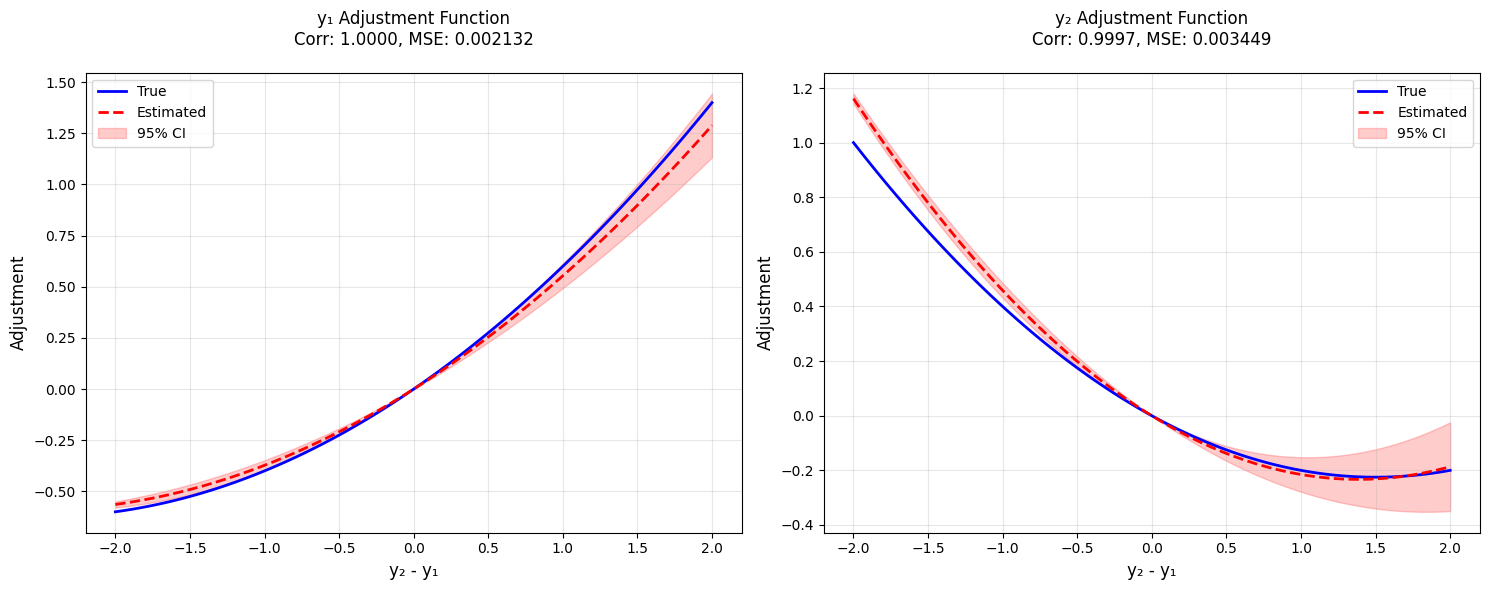

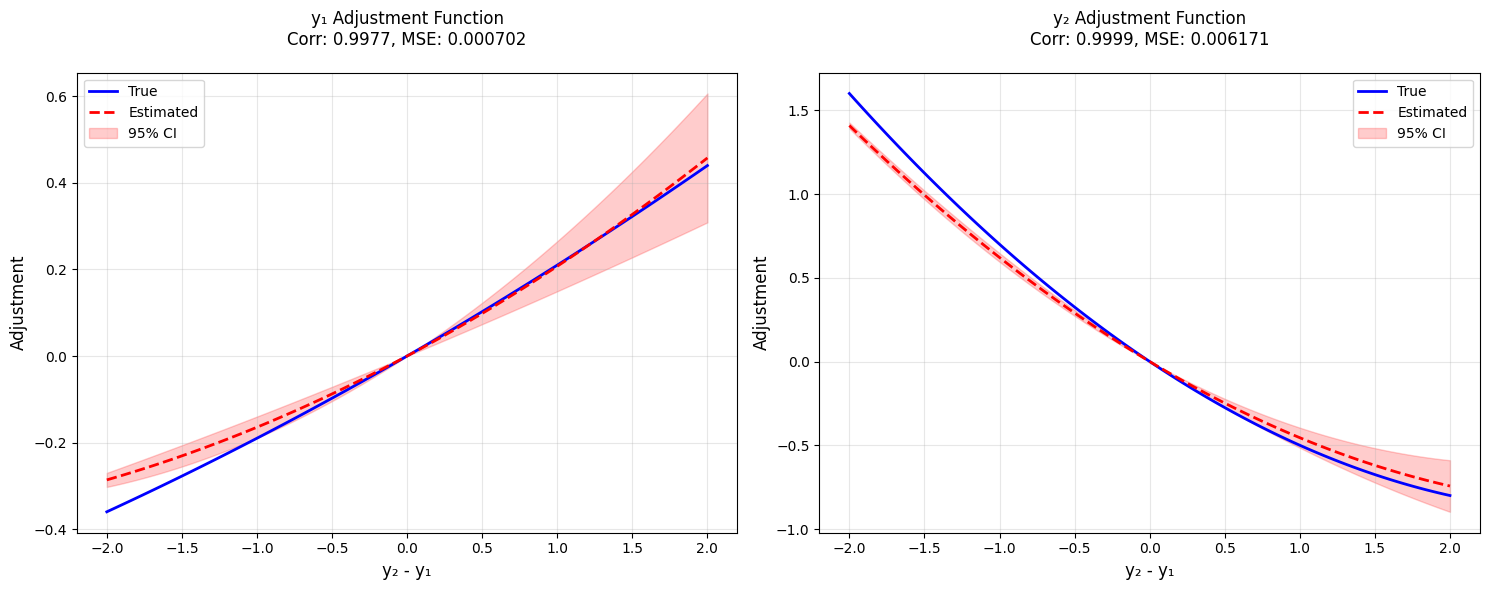

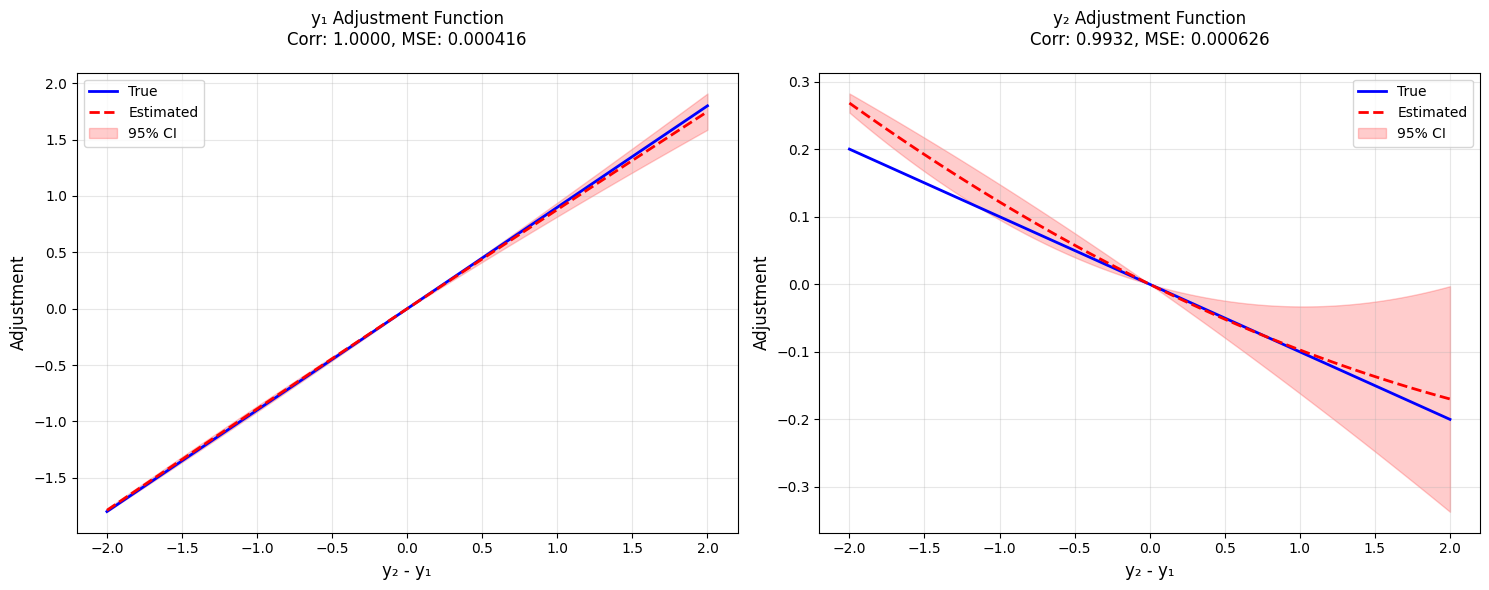

In [3]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd

def test_model_fit(model_results, y1_coef=[0.5, 0.1], y2_coef = [-0.3, 0.0], alpha=0.05, z_range=(-2, 2), n_points=100):
  """
  Plot estimated adjustment functions with confidence intervals and true functions

  True processes:
    y1: α₁(z) = y1_coef_0*z + y1_coef_1*z²
    y2: α₂(z) = y2_coef_0*z + y2_coef_1*z², where z = y2 - y1

  Parameters:
  -----------
  model_results : dict
      Dictionary containing model estimation results
  alpha : float, optional
      Significance level for confidence intervals (default: 0.05)
  z_range : tuple, optional
      Range for the x-axis (z = y2 - y1) (default: (-2, 2))
  n_points : int, optional
      Number of points for plotting (default: 100)
  """

  # Create grid of deviations from equilibrium
  z = np.linspace(z_range[0], z_range[1], n_points)

  # True adjustment functions
  true_adj_y1 = y1_coef[0]*z + y1_coef[1]*z**2
  true_adj_y2 = y2_coef[0]*z + y2_coef[1]*z**2

  # Estimated adjustment functions
  est_adj_y1 = model_results['alpha_y_star'][0] * z + model_results['alpha_prime'][0] * z**2
  est_adj_y2 = model_results['alpha_y_star'][1] * z + model_results['alpha_prime'][1] * z**2

  # Compute correlations
  corr_y1, _ = pearsonr(true_adj_y1, est_adj_y1)
  corr_y2, _ = pearsonr(true_adj_y2, est_adj_y2)

  # Compute mean squared errors
  mse_y1 = np.mean((true_adj_y1 - est_adj_y1)**2)
  mse_y2 = np.mean((true_adj_y2 - est_adj_y2)**2)

  # Print results
  print("\nModel Validation Results:")
  print("--------------------------")
  print(f"Correlation with true process:")
  print(f"y1: {corr_y1:.4f}")
  print(f"y2: {corr_y2:.4f}")
  print(f"\nMean Squared Error:")
  print(f"y1: {mse_y1:.6f}")
  print(f"y2: {mse_y2:.6f}")

  # Compute confidence intervals
  se_linear = model_results['std_errors'][0, :]  # SE for linear terms
  se_quad = model_results['std_errors'][1, :]    # SE for quadratic terms

  # Critical value from t-distribution
  t_crit = stats.t.ppf(1 - alpha/2, df=len(z) - 4)

  # Confidence bands
  ci_y1_lower = (model_results['alpha_y_star'][0] - t_crit*se_linear[0]) * z + \
                (model_results['alpha_prime'][0] - t_crit*se_quad[0]) * z**2
  ci_y1_upper = (model_results['alpha_y_star'][0] + t_crit*se_linear[0]) * z + \
                (model_results['alpha_prime'][0] + t_crit*se_quad[0]) * z**2

  ci_y2_lower = (model_results['alpha_y_star'][1] - t_crit*se_linear[1]) * z + \
                (model_results['alpha_prime'][1] - t_crit*se_quad[1]) * z**2
  ci_y2_upper = (model_results['alpha_y_star'][1] + t_crit*se_linear[1]) * z + \
                (model_results['alpha_prime'][1] + t_crit*se_quad[1]) * z**2

  # Compute fit statistics
  corr_y1, _ = pearsonr(true_adj_y1, est_adj_y1)
  corr_y2, _ = pearsonr(true_adj_y2, est_adj_y2)
  mse_y1 = np.mean((true_adj_y1 - est_adj_y1)**2)
  mse_y2 = np.mean((true_adj_y2 - est_adj_y2)**2)

  # Create figure
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

  # Plot y1 adjustment
  ax1.plot(z, true_adj_y1, 'b-', label='True', linewidth=2)
  ax1.plot(z, est_adj_y1, 'r--', label='Estimated', linewidth=2)
  ax1.fill_between(z, ci_y1_lower, ci_y1_upper, color='r', alpha=0.2,
                    label=f'{int((1-alpha)*100)}% CI')
  ax1.set_title('y₁ Adjustment Function\n' +
                f'Corr: {corr_y1:.4f}, MSE: {mse_y1:.6f}',
                pad=20)
  ax1.set_xlabel('y₂ - y₁', fontsize=12)
  ax1.set_ylabel('Adjustment', fontsize=12)
  ax1.grid(True, alpha=0.3)
  ax1.legend(loc='upper left')

  # Plot y2 adjustment
  ax2.plot(z, true_adj_y2, 'b-', label='True', linewidth=2)
  ax2.plot(z, est_adj_y2, 'r--', label='Estimated', linewidth=2)
  ax2.fill_between(z, ci_y2_lower, ci_y2_upper, color='r', alpha=0.2,
                    label=f'{int((1-alpha)*100)}% CI')
  ax2.set_title('y₂ Adjustment Function\n' +
                f'Corr: {corr_y2:.4f}, MSE: {mse_y2:.6f}',
                pad=20)
  ax2.set_xlabel('y₂ - y₁', fontsize=12)
  ax2.set_ylabel('Adjustment', fontsize=12)
  ax2.grid(True, alpha=0.3)
  ax2.legend(loc='upper right')

  # Adjust layout
  plt.tight_layout()

  # Print results
  print("\nModel Results:")
  print("------------------------")
  print(f"Linear coefficient y1_lower: {model_results['alpha_y_star'][0] - t_crit*se_linear[0]:.2f}")
  print(f"Linear coefficient y1_upper: {model_results['alpha_y_star'][0] + t_crit*se_linear[0]:.2f}")
  print(f"Linear true y1: {y1_coef[0]:.2f}")

  print(f"Quadratic coefficient y1_lower: {model_results['alpha_prime'][0] - t_crit*se_quad[0]:.2f}")
  print(f"Quadratic coefficient y1_upper: {model_results['alpha_prime'][0] + t_crit*se_quad[0]:.2f}")
  print(f"Quadratic true y1: {y1_coef[1]:.2f}")

  print(f"Linear coefficient y2_lower: {model_results['alpha_y_star'][1] - t_crit*se_linear[1]:.2f}")
  print(f"Linear coefficient y2_upper: {model_results['alpha_y_star'][1] + t_crit*se_linear[1]:.2f}")
  print(f"Linear true y2: {y2_coef[0]:.2f}")

  print(f"Quadratic coefficient y2_lower: {model_results['alpha_prime'][1] - t_crit*se_quad[1]:.2f}")
  print(f"Quadratic coefficient y2_upper: {model_results['alpha_prime'][1] + t_crit*se_quad[1]:.2f}")
  print(f"Quadratic true y2: {y2_coef[1]:.2f}")
  print("------------------------")

  return {
      'correlations': {'y1': corr_y1, 'y2': corr_y2},
      'mse': {'y1': mse_y1, 'y2': mse_y2},
      'confidence_bands': {
          'y1': {'lower': ci_y1_lower, 'upper': ci_y1_upper},
          'y2': {'lower': ci_y2_lower, 'upper': ci_y2_upper}
      }
  }

def generate_data(y1_coef, y2_coef, T=1000):
    """ generate data for testing """
    import numpy as np
    np.random.seed(42)

    e1 = np.random.normal(0, 1, T)
    e2 = np.random.normal(0, 1, T)

    y1 = np.zeros(T)
    y2 = np.zeros(T)

    for t in range(1, T):
        y1[t] = y1[t-1] + y1_coef[0]*(y2[t-1] - y1[t-1]) + y1_coef[1]*(y2[t-1] - y1[t-1])**2 + e1[t]
        y2[t] = y2[t-1] + y2_coef[0]*(y2[t-1] - y1[t-1]) + y2_coef[1]*(y2[t-1] - y1[t-1])**2 + e2[t]

    data = pd.DataFrame(np.column_stack([y1, y2]), columns=['y1', 'y2'])
    return data

# Run test with previous model
if __name__ == "__main__":
    # Generate data and fit model as before

    # TEST 1:
    print('-----------TEST 1----------')
    y1_coef = [ 0.5, 0.1]
    y2_coef = [-0.3, 0.1]

    data = generate_data(y1_coef=y1_coef, y2_coef=y2_coef)

    model = NonlinearVECM(data)
    results = model.fit()

    # Run validation
    validation_results = test_model_fit(results,y1_coef=y1_coef, y2_coef=y2_coef)

    # TEST 2:
    print('-----------TEST 2----------')
    y1_coef = [ 0.2, 0.01]
    y2_coef = [-0.6, 0.1 ]

    data = generate_data(y1_coef=y1_coef, y2_coef=y2_coef)

    model = NonlinearVECM(data)
    results = model.fit()

    # Run validation
    validation_results = test_model_fit(results,y1_coef=y1_coef, y2_coef=y2_coef)

    # TEST 3:
    print('-----------TEST 3----------')
    y1_coef = [ 0.9, 0.0]
    y2_coef = [-0.1, 0.0]

    data = generate_data(y1_coef=y1_coef, y2_coef=y2_coef)

    model = NonlinearVECM(data)
    results = model.fit()

    # Run validation
    validation_results = test_model_fit(results,y1_coef=y1_coef, y2_coef=y2_coef)